In [2]:
import sys
import numpy as np
import matplotlib.pyplot as pyp
import xarray as xr
import importlib
import matplotlib.animation as animation
from IPython.display import HTML

In [5]:
sys.path.append("../..")
sys.path.append("..")

In [6]:
import wavetracer as trace

In [83]:
x0 = np.linspace(0,0,5)
z0 = np.linspace(0,-10,5)

In [84]:
params_testing = {
    'a': 1,           # Wave amplitude
    'lam': 100,           # wavelength
    'H': 1000,           # Water depth
    'order': 'leading',   # Approximation order
}

In [85]:
ds = trace.build_dataset(x0=x0, z0=z0, random_pos=True, N=300, x_min=-7, x_max=7, H_particles=10)

In [86]:
ds_0_d = trace.compute_trajectories(ds, duration=50, **params_testing)

In [87]:
params_testing = {
    'a': 1,           # Wave amplitude
    'lam': 100,           # wavelength
    'H': 1000,           # Water depth
    'order': 'first',   # Approximation order
}

In [88]:
ds_1_d = trace.compute_trajectories(ds, duration=50, **params_testing)

In [89]:
params_testing = {
    'a': 1,           # Wave amplitude
    'lam': 100,           # wavelength
    'H': 10,           # Water depth
    'order': 'leading',   # Approximation order
}

In [90]:
ds_0_s = trace.compute_trajectories(ds, duration=50, **params_testing)

In [91]:
params_testing = {
    'a': 1,           # Wave amplitude
    'lam': 100,           # wavelength
    'H': 10,           # Water depth
    'order': 'first',   # Approximation order
}

In [92]:
ds_1_s = trace.compute_trajectories(ds, duration=50, **params_testing)

In [93]:
ds_0_d

<xarray.Dataset>
Dimensions:   (particle: 305, time: 1189, point: 10)
Coordinates:
  * particle  (particle) int64 0 1 2 3 4 5 6 7 ... 298 299 300 301 302 303 304
  * time      (time) float64 0.0 0.04207 0.08414 0.1262 ... 49.89 49.93 49.98
Dimensions without coordinates: point
Data variables:
    x0        (particle) float64 0.0 0.0 0.0 0.0 ... -2.207 4.055 -5.687 6.41
    z0        (particle) float64 0.0 -2.5 -5.0 -7.5 ... -7.447 -3.45 -3.76
    xp        (particle, time) float64 0.0 0.2588 0.5 ... 7.041 6.896 6.719
    zp        (particle, time) float64 1.0 0.9659 0.866 ... -4.235 -4.382 -4.487
    x_eta     (time, point) float64 -16.12 -12.48 -8.885 ... 10.0 13.96 17.88
    z_eta     (time, point) float64 0.4818 0.6743 0.829 ... -0.6743 -0.4818
Attributes:
    a:        {'value': 1, 'description': 'Wave amplitude (meters)'}
    H:        {'value': 1000, 'description': 'Water depth (meters)'}
    k:        {'value': 0.06283185307179587, 'description': 'Wavenumber (1/me...
    lam:      {'value': 100, 'description': 'Wavelength (meters)'}
    order:    {'value': 'leading', 'description': 'Approximation order ("lead...

In [127]:
t = 100

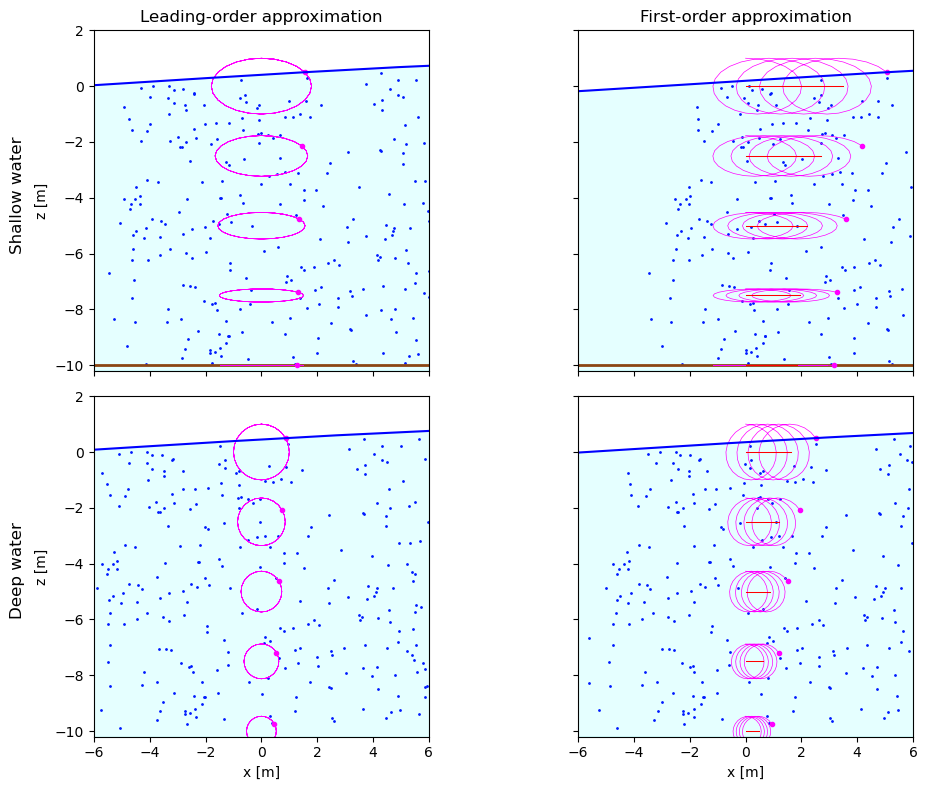

In [176]:
import matplotlib.pyplot as plt

# Create figure and axes
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), sharex=True, sharey=True)

# Organize datasets
datasets = [[ds_0_s, ds_1_s], [ds_0_d, ds_1_d]]  # rows: shallow, deep; cols: 0, 1

# Define axis limits
xlims = (-6, 6)
ylims = (-10.2, 2)

# Plotting loop
for i, row in enumerate(datasets):  # i=0 (shallow), i=1 (deep)
    for j, ds in enumerate(row):   # j=0 (0th order), j=1 (1st order)
        ax = axs[i, j]

        # Add brown bottom line for shallow row only
        if i == 0:
            ax.axhline(-10, color='saddlebrown', linewidth=2)

        # Get data at time step t
        xp_t = ds.xp.isel(time=t)
        zp_t = ds.zp.isel(time=t)
        x_eta_t = ds.x_eta.isel(time=t)
        z_eta_t = ds.z_eta.isel(time=t)

        # Scatter plot of current particle positions
        ax.scatter(xp_t, zp_t, s=1, color='blue', label='Particles @ t')

        # Plot trajectories for particles with x0 == 0
        mask = (ds.x0 == 0).values
        xp_sel = ds.xp.sel(particle=mask)
        zp_sel = ds.zp.sel(particle=mask)

        for p in xp_sel.particle.values:
            xp_line = xp_sel.sel(particle=p).isel(time=slice(0, t+1))
            zp_line = zp_sel.sel(particle=p).isel(time=slice(0, t+1))
            ax.plot(xp_line, zp_line, color='magenta', alpha=1, linewidth=0.5)
            ax.plot(xp_line.isel(time=-1), zp_line.isel(time=-1), 'o', color='magenta', markersize=3)

        # Compute the difference for particles at x0 == 0 only in the right column (j==1)
        if j == 1:  # Right column only (leading-order approximation)
            if i == 0:  # Shallow model
                xp0_s = ds_0_s.xp.isel(time=slice(0,t)).sel(particle=mask)
                xp1_s = ds_1_s.xp.isel(time=slice(0,t)).sel(particle=mask)
                zp1_s = np.tile(ds_1_s.z0.sel(particle=mask).values, (t, 1))
                xp_diff_s = xp1_s - xp0_s
                for p in xp_sel.particle:
                    xdiff_line = xp_diff_s.sel(particle=p)
                    ax.plot(xdiff_line, zp1_s[:,p], color='red', alpha=1, linewidth=0.75)
            elif i == 1:  # Deep model
                xp0_d = ds_0_d.xp.isel(time=slice(0,t)).sel(particle=mask)
                xp1_d = ds_1_d.xp.isel(time=slice(0,t)).sel(particle=mask)
                zp1_d = np.tile(ds_1_d.z0.sel(particle=mask).values, (t, 1))
                xp_diff_d = xp1_d - xp0_d
                for p in xp_sel.particle:
                    xdiff_line = xp_diff_d.sel(particle=p)
                    ax.plot(xdiff_line, zp1_d[:,p], color='red', alpha=1, linewidth=0.75)

        # Plot free surface
        ax.plot(x_eta_t, z_eta_t, color='blue', label='Free surface')

        # Fill under free surface
        ax.fill_between(x_eta_t, z_eta_t, ylims[0], color='aqua', alpha=0.1)

        # Set axis labels
        if i == 1:
            ax.set_xlabel('x [m]')
        if j == 0:
            ax.set_ylabel('z [m]')

        # Set limits and aspect ratio
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_aspect('equal')

# Set top column titles
axs[0, 0].set_title("Leading-order approximation")
axs[0, 1].set_title("First-order approximation")

# Add row labels as vertical text
fig.text(0.13, 0.75, "Shallow water", va='center', ha='center', rotation='vertical', fontsize=12)
fig.text(0.13, 0.28, "Deep water", va='center', ha='center', rotation='vertical', fontsize=12)

plt.tight_layout(rect=[0.07, 0, 1, 1])  # Leave room for the vertical row labels
plt.show()


In [173]:
zp1_s[:,0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [161]:
xp_diff_s.isel(particle=4).max()

<xarray.DataArray 'xp' ()>
array(1.8461852)
Coordinates:
    particle  int64 4

In [138]:
ds_0_s.xp.isel(time=t).sel(particle=mask)


<xarray.DataArray 'xp' (particle: 5)>
array([1.55510112, 1.43773082, 1.35590812, 1.30760995, 1.29164217])
Coordinates:
  * particle  (particle) int64 0 1 2 3 4
    time      float64 44.68

Particles selected for model 0, approx 0: 5
Particles selected for model 0, approx 1: 5
Particle <xarray.DataArray 'particle' ()>
array(0)
Coordinates:
    particle  int64 0 difference computed: xp_diff = <xarray.DataArray 'xp' ()>
array(0.)
Coordinates:
    particle  int64 0
    time      float64 44.68, zp_diff = <xarray.DataArray 'zp' ()>
array(0.)
Coordinates:
    particle  int64 0
    time      float64 44.68
Particle <xarray.DataArray 'particle' ()>
array(1)
Coordinates:
    particle  int64 1 difference computed: xp_diff = <xarray.DataArray 'xp' ()>
array(0.)
Coordinates:
    particle  int64 1
    time      float64 44.68, zp_diff = <xarray.DataArray 'zp' ()>
array(0.)
Coordinates:
    particle  int64 1
    time      float64 44.68
Particle <xarray.DataArray 'particle' ()>
array(2)
Coordinates:
    particle  int64 2 difference computed: xp_diff = <xarray.DataArray 'xp' ()>
array(0.)
Coordinates:
    particle  int64 2
    time      float64 44.68, zp_diff = <xarray.DataArray 'zp' ()>
a

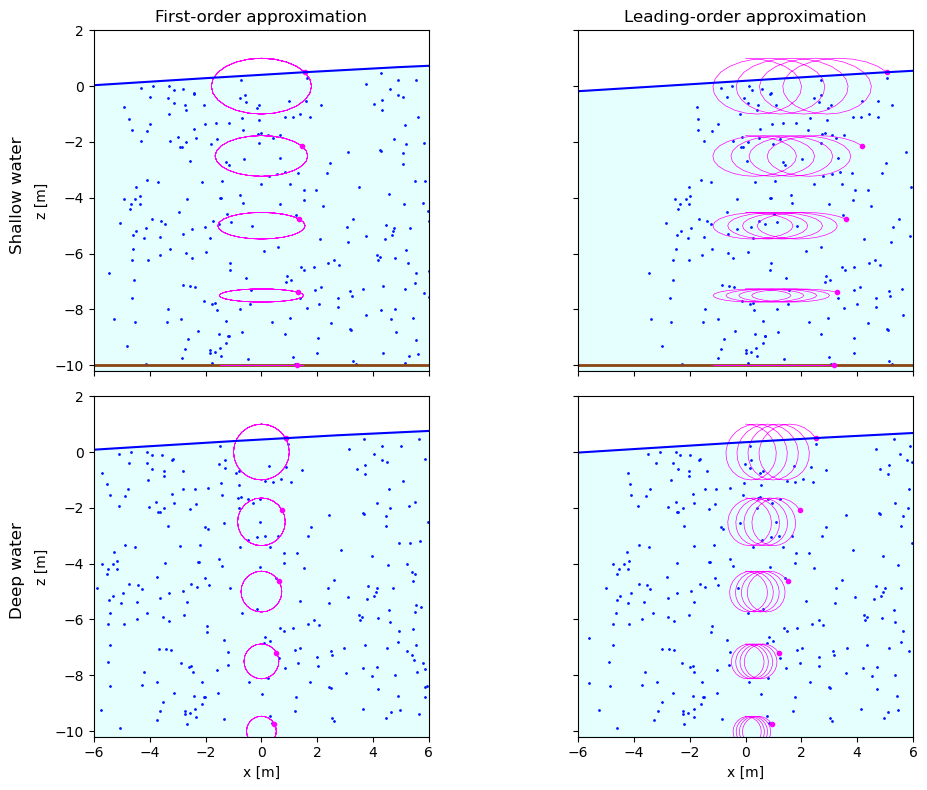

In [141]:
import matplotlib.pyplot as plt

# Create figure and axes
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), sharex=True, sharey=True)

# Organize datasets
datasets = [[ds_0_s, ds_1_s], [ds_0_d, ds_1_d]]  # rows: shallow, deep; cols: 0, 1

# Define axis limits
xlims = (-6, 6)
ylims = (-10.2, 2)

# Plotting loop
for i, row in enumerate(datasets):  # i=0 (shallow), i=1 (deep)
    for j, ds in enumerate(row):   # j=0 (0th order), j=1 (1st order)
        ax = axs[i, j]

        # Add brown bottom line for shallow row only
        if i == 0:
            ax.axhline(-10, color='saddlebrown', linewidth=2)

        # Get data at time step t
        xp_t = ds.xp.isel(time=t)
        zp_t = ds.zp.isel(time=t)
        x_eta_t = ds.x_eta.isel(time=t)
        z_eta_t = ds.z_eta.isel(time=t)

        # Scatter plot of current particle positions
        ax.scatter(xp_t, zp_t, s=1, color='blue', label='Particles @ t')

        # Plot trajectories for particles with x0 == 0
        mask = (ds.x0 == 0).values
        xp_sel = ds.xp.sel(particle=mask)
        zp_sel = ds.zp.sel(particle=mask)

        # Debug: Check number of particles with x0 == 0
        print(f"Particles selected for model {i}, approx {j}: {len(xp_sel.particle)}")

        # Loop over each particle with x0 == 0
        for p in xp_sel.particle:
            xp_line_0 = xp_sel.sel(particle=p).isel(time=slice(0, t+1))
            zp_line_0 = zp_sel.sel(particle=p).isel(time=slice(0, t+1))
            ax.plot(xp_line_0, zp_line_0, color='magenta', alpha=1, linewidth=0.5)
            ax.plot(xp_line_0.isel(time=-1), zp_line_0.isel(time=-1), 'o', color='magenta', markersize=3)

            # Compute the difference for this particle (only in right column)
            if j == 1:  # Right column only (leading-order approximation)
                if i == 0:  # Shallow model
                    xp_line_1 = ds_1_s.xp.sel(particle=p).isel(time=slice(0, t+1))
                    zp_line_1 = ds_1_s.zp.sel(particle=p).isel(time=slice(0, t+1))
                elif i == 1:  # Deep model
                    xp_line_1 = ds_1_d.xp.sel(particle=p).isel(time=slice(0, t+1))
                    zp_line_1 = ds_1_d.zp.sel(particle=p).isel(time=slice(0, t+1))

                # Compute the difference
                xp_diff = xp_line_1 - xp_line_0
                zp_diff = zp_line_1 - zp_line_0

                # Debug: Check if the difference is calculated
                if len(xp_diff) > 0:
                    print(f"Particle {p} difference computed: xp_diff = {xp_diff[-1]}, zp_diff = {zp_diff[-1]}")

                # Plot the difference
                ax.plot(xp_diff, zp_diff, color='red', alpha=0.7, linewidth=1, label='Difference')

        # Plot free surface
        ax.plot(x_eta_t, z_eta_t, color='blue', label='Free surface')

        # Fill under free surface
        ax.fill_between(x_eta_t, z_eta_t, ylims[0], color='aqua', alpha=0.1)

        # Set axis labels
        if i == 1:
            ax.set_xlabel('x [m]')
        if j == 0:
            ax.set_ylabel('z [m]')

        # Set limits and aspect ratio
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_aspect('equal')

# Set top column titles
axs[0, 0].set_title("First-order approximation")
axs[0, 1].set_title("Leading-order approximation")

# Add row labels as vertical text
fig.text(0.13, 0.75, "Shallow water", va='center', ha='center', rotation='vertical', fontsize=12)
fig.text(0.13, 0.28, "Deep water", va='center', ha='center', rotation='vertical', fontsize=12)

plt.tight_layout(rect=[0.07, 0, 1, 1])  # Leave room for the vertical row labels
plt.show()


In [132]:
xp0d = ds_0_d.sel(time=slice(0,10)).isel(particle=0).xp
zp0d = ds_0_d.sel(time=slice(0,10)).isel(particle=0).zp
xp1d = ds_1_d.sel(time=slice(0,10)).isel(particle=0).xp
zp1d = ds_1_d.sel(time=slice(0,10)).isel(particle=0).zp

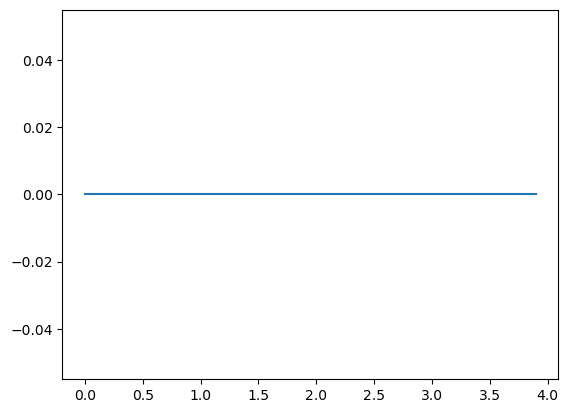

In [134]:
plt.plot(xp1d-xp0d, zp1d-zp0d)